<a href="https://colab.research.google.com/github/Elshan777/MIT-Indoor-Scenes/blob/master/SAML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is March 25**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Elshan Gadimov** 

**Neptun ID: OV7MIK** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [2]:
# ADD YOUR CODE HERE
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import shutil
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid 
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

In [3]:
#!pip install kaggle

#! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/

#! chmod 600 ~/.kaggle/kaggle.json

os.environ['KAGGLE_USERNAME'] = "elshangadimov"
os.environ['KAGGLE_KEY'] = "dc78ef611b838449f7a58960e2a15014"

! kaggle datasets download itsahmad/indoor-scenes-cvpr-2019

100% 2.33G/2.34G [00:11<00:00, 242MB/s]
100% 2.34G/2.34G [00:11<00:00, 213MB/s]


In [ ]:
! unzip indoor-scenes-cvpr-2019

In [5]:
# Reading the data
data_dir  = '/content/indoorCVPR_09/Images'

classes = os.listdir(data_dir)
print(classes)
print(len(classes), "Existing classes")

['inside_bus', 'grocerystore', 'nursery', 'pantry', 'studiomusic', 'museum', 'lobby', 'computerroom', 'artstudio', 'restaurant_kitchen', 'poolinside', 'bakery', 'hairsalon', 'buffet', 'laboratorywet', 'prisoncell', 'dining_room', 'corridor', 'greenhouse', 'locker_room', 'livingroom', 'operating_room', 'kindergarden', 'winecellar', 'mall', 'subway', 'garage', 'children_room', 'restaurant', 'bookstore', 'classroom', 'inside_subway', 'bedroom', 'church_inside', 'clothingstore', 'auditorium', 'deli', 'kitchen', 'trainstation', 'fastfood_restaurant', 'jewelleryshop', 'bowling', 'concert_hall', 'waitingroom', 'stairscase', 'cloister', 'bar', 'warehouse', 'hospitalroom', 'library', 'gameroom', 'bathroom', 'laundromat', 'casino', 'toystore', 'dentaloffice', 'office', 'tv_studio', 'closet', 'gym', 'meeting_room', 'movietheater', 'videostore', 'florist', 'airport_inside', 'shoeshop', 'elevator']
67 Existing classes


In [6]:
# Delete some folders (classes) and keep only 5
kept_classes = ['casino', 'hairsalon', 'grocerystore', 'gym', 'bedroom']
for i in classes:
  if i not in kept_classes:
    try:
        shutil.rmtree(data_dir+'/'+i)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

classes = os.listdir(data_dir)
os.listdir(data_dir)

['grocerystore', 'hairsalon', 'bedroom', 'casino', 'gym']

In [7]:
# ADD YOUR CODE HERE

mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# 
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((256, 256)), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

dataset = ImageFolder(data_dir, transform = transformations)


len(dataset)

1860

In [8]:
dataset.classes

['bedroom', 'casino', 'grocerystore', 'gym', 'hairsalon']

In [9]:
# Defining the random seed for torch
random_seed = 42
torch.manual_seed(random_seed)

#### Splitting the dataset

In [10]:
# I did a 80:10:10 split
train_ds, val_ds, test_ds = random_split(dataset, [1488, 186, 186])
len(train_ds), len(val_ds), len(test_ds)

(1488, 186, 186)

In [11]:
batch_size = 3

train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True, num_workers=2)
valid_dl = DataLoader(val_ds,batch_size=batch_size, num_workers=2)
test_dl = DataLoader(test_ds,batch_size=batch_size,num_workers=2)

## Showing the batch

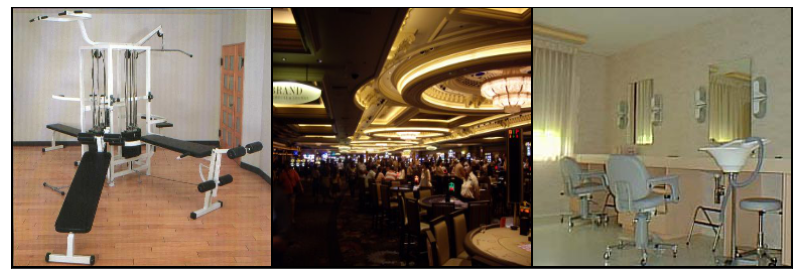

In [12]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_dl.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, mean, std)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], mean, std)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
# ADD YOUR CODE HERE


#### Pre-processing the dataset

In [ ]:
# ADD YOUR CODE HERE

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [106]:
# ADD YOUR CODE HERE

# Loading pre trained Alexnet from Pytorch
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Fine tuning the model

In [107]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, out_features=len(classes))

model_ft = model_ft.to(device)

In [108]:
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [109]:
# Summary
from torchsummary import summary
summary(model_ft, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Define your optimizer and loss function

In [110]:
# ADD YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

In [111]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=3, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = './cifar_best_net.pth'

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model_ft.state_dict(), self.best_model)
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

early_stopping = EarlyStopping()

#### Train your network

In [112]:
def evaluate():
  running_loss = 0.0
  
  with torch.no_grad():
    for i, data in enumerate(valid_dl, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model_ft(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
  val_loss = running_loss / len(valid_dl)
  print('val loss: %.3f' % (val_loss))
  return val_loss


def eval_acc(train=False):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      loader = train_dl if train else valid_dl
      for data in loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = model_ft(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  
  print('Accuracy of the network on the %s images: %d %%' % (
      'train' if train else 'test', 100 * correct / total))

In [113]:
# ADD YOUR CODE HERE
def train():
  NUM_EPOCHS = 10
  for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
      print(f'Epoch {epoch+1}:')
      running_loss = 0.0
      for i, data in enumerate(train_dl, 0):
          # get the inputs; data is a list of [inputs, labels]
          #inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device) #set for GPU if available

          # zero the parameter gradients
          optimizer_ft.zero_grad()

          # forward + backward + optimize
          outputs = model_ft(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer_ft.step()

          # print statistics
          running_loss += loss.item()
          if i % 250 == 0 and i!= 0: 
              print(f'Iteration {i}, loss = {(running_loss / 250):.3f}')
              running_loss = 0.0

      val_loss = evaluate()
      eval_acc()
      early_stopping(val_loss)
      if early_stopping.early_stop:
          break

  print('Finished Training')

#### Show results (accuracy and loss) on training and validation sets

In [114]:
train()

Epoch 1:
Iteration 250, loss = 1.150
val loss: 0.808
Accuracy of the network on the test images: 68 %
Epoch 2:
Iteration 250, loss = 0.615
val loss: 0.528
Accuracy of the network on the test images: 81 %
Epoch 3:
Iteration 250, loss = 0.450
val loss: 0.406
Accuracy of the network on the test images: 84 %
Epoch 4:
Iteration 250, loss = 0.334
val loss: 0.570
Accuracy of the network on the test images: 82 %
INFO: Early stopping counter 1 of 3
Epoch 5:
Iteration 250, loss = 0.297
val loss: 0.476
Accuracy of the network on the test images: 84 %
INFO: Early stopping counter 2 of 3
Epoch 6:
Iteration 250, loss = 0.108
val loss: 0.600
Accuracy of the network on the test images: 82 %
INFO: Early stopping counter 3 of 3
INFO: Early stopping
Finished Training


In [115]:
# Save the model
PATH = './mit-indoors_5_6.pth'
torch.save(model_ft, PATH)

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [41]:
# ADD YOUR CODE HERE
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the ',test_dl.dataset.__len__(),' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  186  test images: 83 %


#### Show some predictions

In [119]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: gym , Predicted: gym


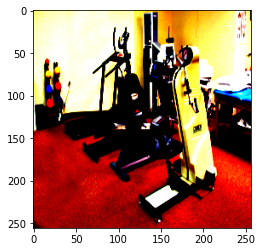

In [123]:
model = torch.load(PATH)
img, label = test_ds[15]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bedroom , Predicted: bedroom


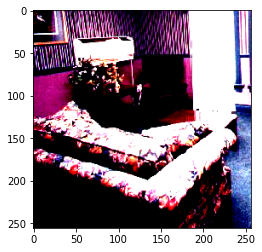

In [122]:
img, label = test_ds[30]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

#### Answer the questions

In [124]:
# ADD YOUR ANSWERS HERE

#How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

In [126]:
eval_acc()

Accuracy of the network on the test images: 83 %


The test accuracy is 83% and according to what I've heard in the class the baseline is 50% so I would assume it is a good result.

In [127]:
eval_acc(train=True)

Accuracy of the network on the train images: 93 %


Accuracy of train data is 93% and this tells us that our model is overfitted we could use some regularization or change some hyperparameters. Like decreaseing the learning rate or etc. Also we did 80:10:10 split for train, validation and  test. A bigger train data and small test data could also lead to  overfitting